In [9]:
import sys
sys.path.append('../helpers/')

import cv2
from pathlib import Path
import numpy as np
import os
from glob import glob
import natsort
import matplotlib.pyplot as plt

# importing packages
from preprocessing import Preprocessing # for resizing

preprocessor = Preprocessing()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2


### 1st approach

In [2]:
# Reference: Multi-class multi-level classification algorithm for skin lesions classification using machine learning techniques
# Authors: Nazia Hameed, Antesar M. Shabut, Miltu K. Ghosh, M.A. Hossain 
def extract_hair(img):
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clip_limit = 1.0 
    tile_size = 10
    CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
    img_CLAHE = CLAHE.apply(img_grayscale)

    kernel_size = 5
    averaged_image = cv2.blur(img_grayscale, (kernel_size, kernel_size))

    hair_mask = img_CLAHE - averaged_image

    _ , thr_img = cv2.threshold(hair_mask, 0 ,255, cv2.THRESH_OTSU)

    p = 3
    structElemOpening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (p, p))
    img_opening = cv2.morphologyEx(thr_img, cv2.MORPH_OPEN, structElemOpening)
    
    inpainted_img = cv2.inpaint(img, img_opening, inpaintRadius=10, flags=cv2.INPAINT_NS)

    return inpainted_img

### 2nd approach

In [145]:
# Reference: An effective hair removal algorithm for dermoscopyimages

def extract_hair_2(img):

    # Convert RGB to grayscale
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clip_limit = 1.0 # 10.0
    tile_size = 10 # 6
    CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
    img_CLAHE = CLAHE.apply(img_grayscale)

    # Apply Gaussian filter
    filter_size = 5
    filtered_image = cv2.GaussianBlur(img_CLAHE, (filter_size, filter_size), 0)

    # Canny edge detection
    # Calculate the median pixel value of the image
    median_value = np.median(filtered_image)
    # Define high and low thresholds for Canny
    high_threshold = median_value + 75
    low_threshold = median_value - 75
    # Apply Canny edge detection with the selected thresholds
    edges = cv2.Canny(filtered_image, low_threshold, high_threshold)

    # Dilation
    # Define the size of the dilation kernel (structuring element)
    kernel_size = (9, 9)  # Adjust the size as needed
    # Perform dilation
    dilated_image = cv2.dilate(edges, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size))

    inpainted_img = cv2.inpaint(img, dilated_image, inpaintRadius=5, flags=cv2.INPAINT_TELEA) # INPAINT_NS

    return inpainted_img

In [91]:
ROOT_PATH = Path(Path(os.getcwd())/"../challenge1")
TRAIN_PATH = ROOT_PATH/"train"
VAL_PATH = ROOT_PATH/"val"

train_nevus = sorted(glob(str(TRAIN_PATH/'nevus/*')))
train_others = sorted(glob(str(TRAIN_PATH/'others/*')))

In [170]:
img = cv2.imread(train_nevus[1146])

image_resized = preprocessor.resize_images(img, preserve_ratio=True)

img_extractedHair = extract_hair(image_resized)
img_extractedHair_2 = extract_hair_2(image_resized)

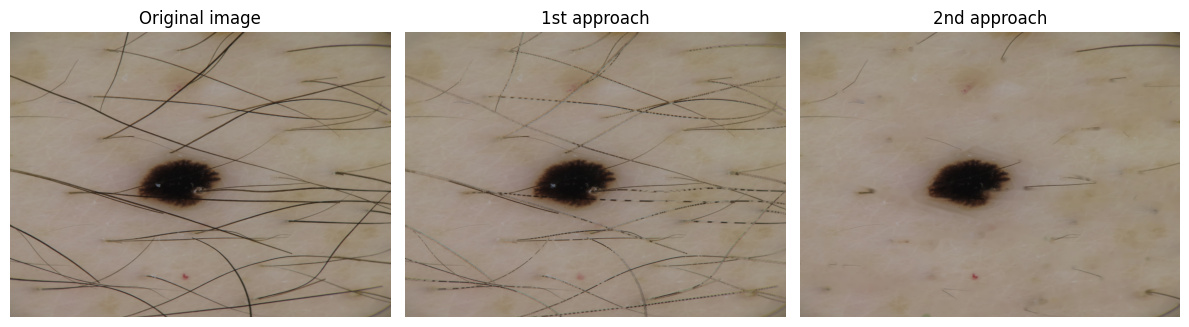

In [172]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_extractedHair, cv2.COLOR_BGR2RGB))
plt.title('1st approach')
plt.axis('off')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_extractedHair_2, cv2.COLOR_BGR2RGB))
plt.title('2nd approach')
plt.axis('off')
plt.tight_layout()

## From here to the end is the step by step pipeline to see the intermediate results and parameter tuning

### 1st approach

(-0.5, 799.5, 599.5, -0.5)

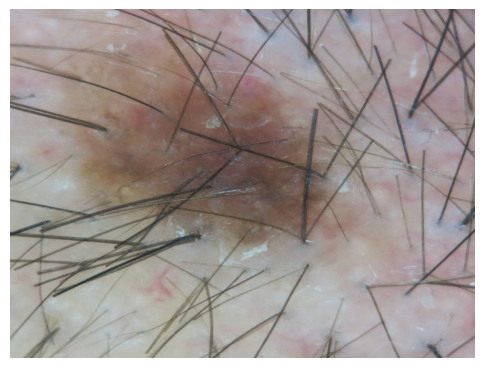

In [17]:
plt.figure(figsize=(6, 6))
img = cv2.imread(train_nevus[6])
image_resized = preprocessor.resize_images(img, preserve_ratio=True)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

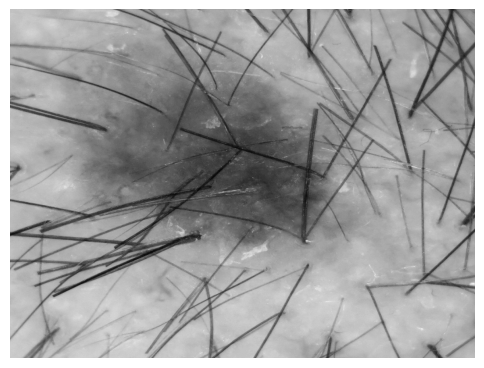

In [18]:
img_grayscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(img_grayscale, cmap='gray')
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

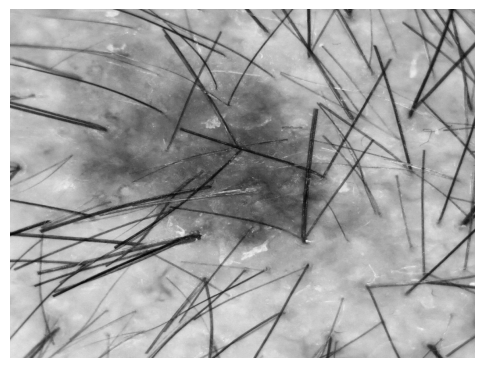

In [20]:
clip_limit = 1.0 # 10.0
tile_size = 10 # 6

#smoothed_image = cv2.blur(img_grayscale, (5, 5))
CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
img_CLAHE = CLAHE.apply(img_grayscale)

plt.figure(figsize=(6, 6))
plt.imshow(img_CLAHE, cmap='gray')
plt.axis('off')

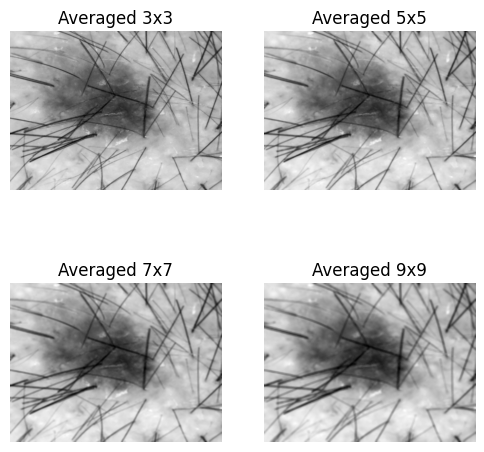

In [21]:
# Define kernel sizes for the average filters
kernel_sizes = [3, 5, 7, 9]


# Create an empty list to store the averaged images
averaged_images = []

# Apply average filters with different kernel sizes
for kernel_size in kernel_sizes:
    # Apply the average filter
    #averaged_image = cv2.blur(img_CLAHE, (kernel_size, kernel_size))
    averaged_image = cv2.blur(img_grayscale, (kernel_size, kernel_size))
    
    # Append the averaged image to the list
    averaged_images.append(averaged_image)


# Display the averaged images for different kernel sizes
plt.figure(figsize=(6, 6))
plt.tight_layout()
for i, kernel_size in enumerate(kernel_sizes):
    plt.subplot(2, 2, i+1)
    plt.imshow(averaged_images[i], cmap='gray')
    plt.title(f'Averaged {kernel_size}x{kernel_size}')
    plt.axis('off')
    

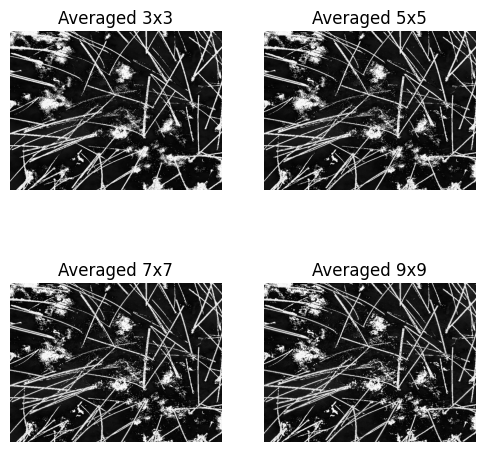

In [22]:
hair_masks = []
for i in range(len(kernel_sizes)):
    #hair_masks.append(averaged_images[i] - img_CLAHE)
    hair_masks.append(img_CLAHE - averaged_images[i])

plt.figure(figsize=(6, 6))
plt.tight_layout()
for i, kernel_size in enumerate(kernel_sizes):
    plt.subplot(2, 2, i+1)
    plt.imshow(hair_masks[i], cmap='gray')
    plt.title(f'Averaged {kernel_size}x{kernel_size}')
    plt.axis('off')

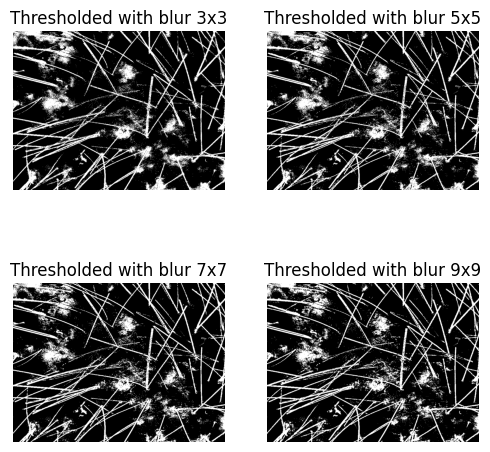

In [44]:
thresholded_imgs = []

for i in range(len(kernel_sizes)):
    _ , thr_img = cv2.threshold(hair_masks[i], 0 ,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_imgs.append(thr_img)

plt.figure(figsize=(6, 6))
plt.tight_layout()
for i, kernel_size in enumerate(kernel_sizes):
    plt.subplot(2, 2, i+1)
    plt.imshow(thresholded_imgs[i], cmap='gray')
    plt.title(f'Thresholded with blur {kernel_size}x{kernel_size}')
    plt.axis('off')

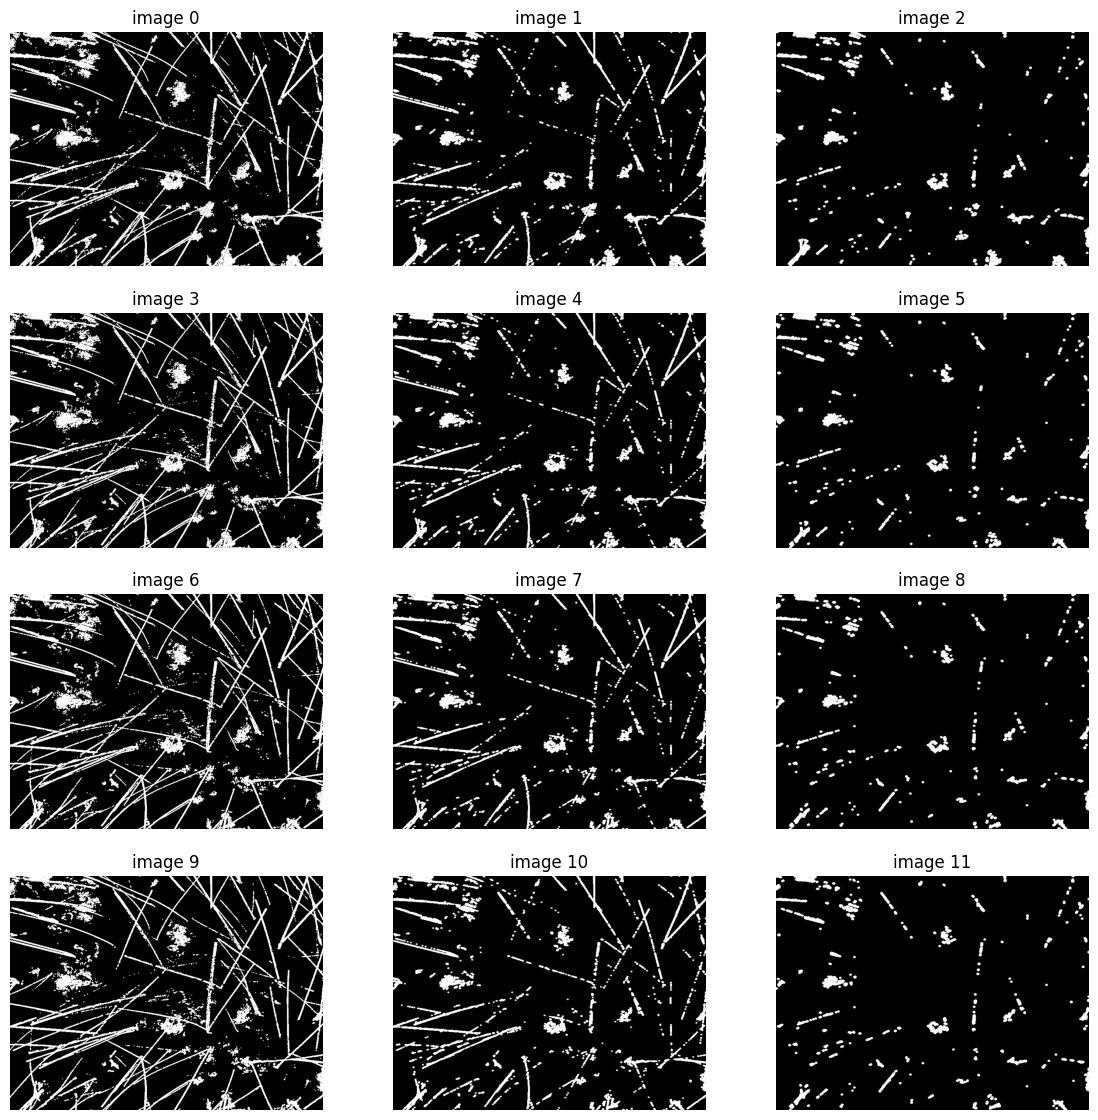

In [45]:
p_values = [3, 5, 7] #[10, 30, 50]
opening_images = []

for i in range(len(thresholded_imgs)):
    for j, p in enumerate(p_values):
        structElemOpening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (p, p))
        img_opening = cv2.morphologyEx(thresholded_imgs[i], cv2.MORPH_OPEN, structElemOpening)
        opening_images.append(img_opening)


plt.figure(figsize=(14, 14))
plt.tight_layout()
for i in range(len(opening_images)):
    plt.subplot(4, 3, i+1)
    plt.imshow(opening_images[i], cmap='gray')
    plt.title(f'image {i}')
    plt.axis('off')

12


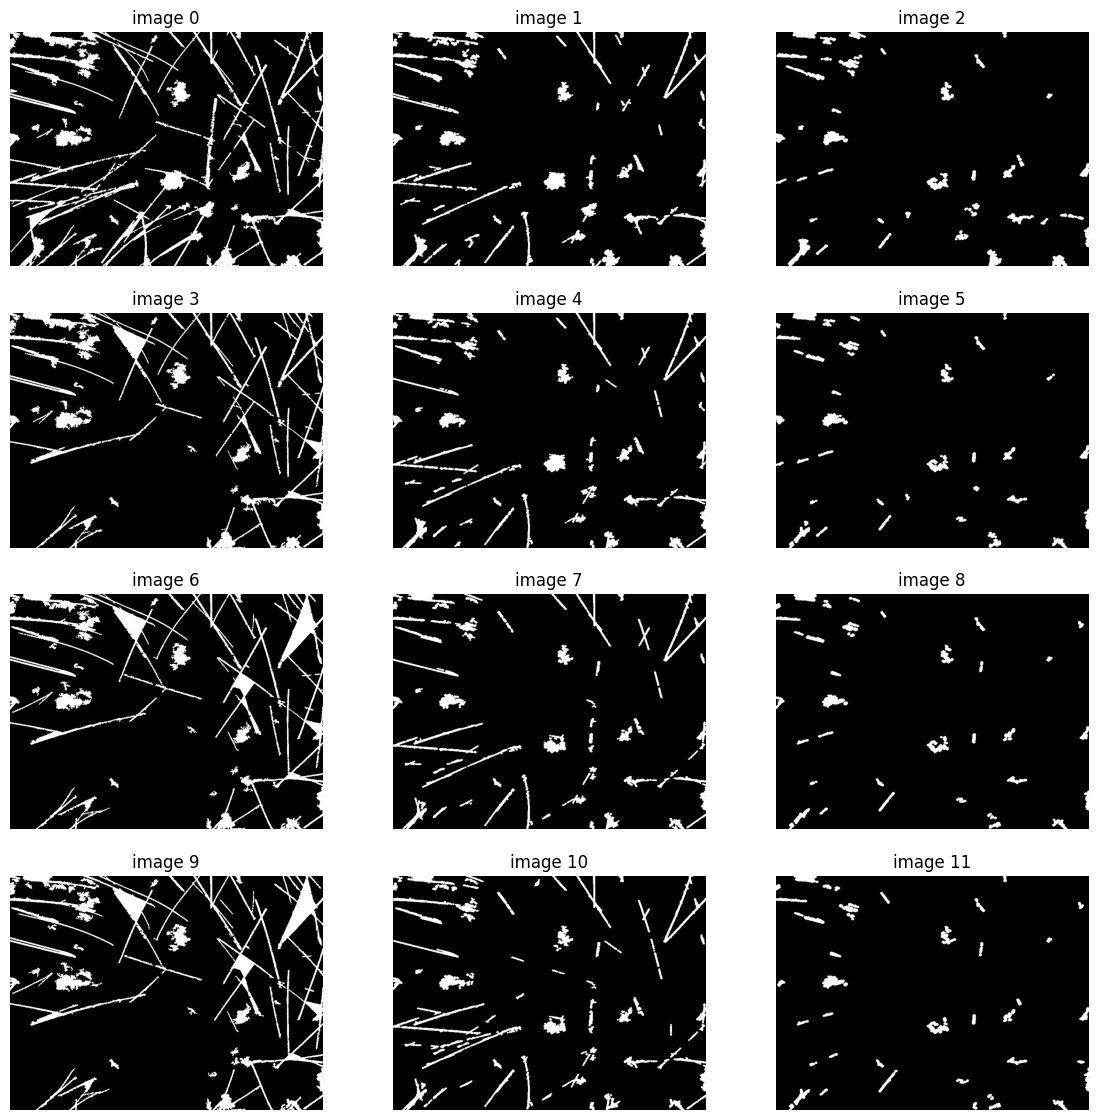

In [52]:
# eliminate too small and too big connected components
filtered_images = []

for i in range(len(opening_images)):
    filtered_mask = np.zeros_like(opening_images[i])

    contours, _ = cv2.findContours(opening_images[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Define the minimum and maximum size of connected components you want to keep
    min_size = 100  # Adjust this threshold as needed
    max_size = 20000  # Adjust this threshold as needed

    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_size <= area <= max_size:
            filtered_contours.append(contour)
  
    cv2.drawContours(filtered_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)
    filtered_images.append(filtered_mask)

print(len(filtered_images))


plt.figure(figsize=(14, 14))
plt.tight_layout()
for i in range(len(opening_images)):
    plt.subplot(4, 3, i+1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f'image {i}')
    plt.axis('off')
    

(-0.5, 799.5, 599.5, -0.5)

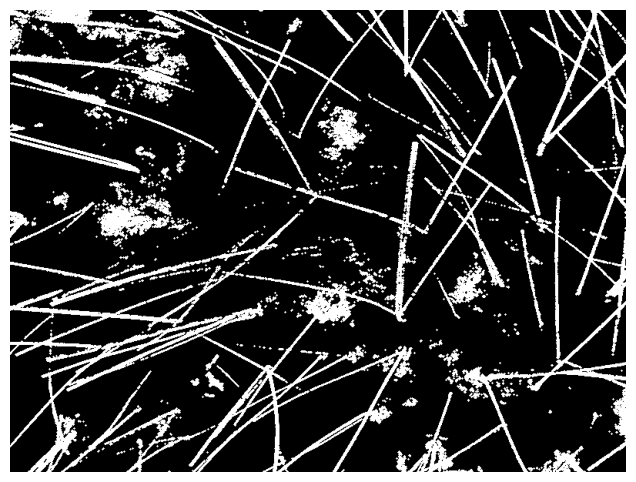

In [41]:
plt.figure(figsize=(12, 6))
plt.imshow(opening_images[6], cmap='gray')
plt.axis('off')

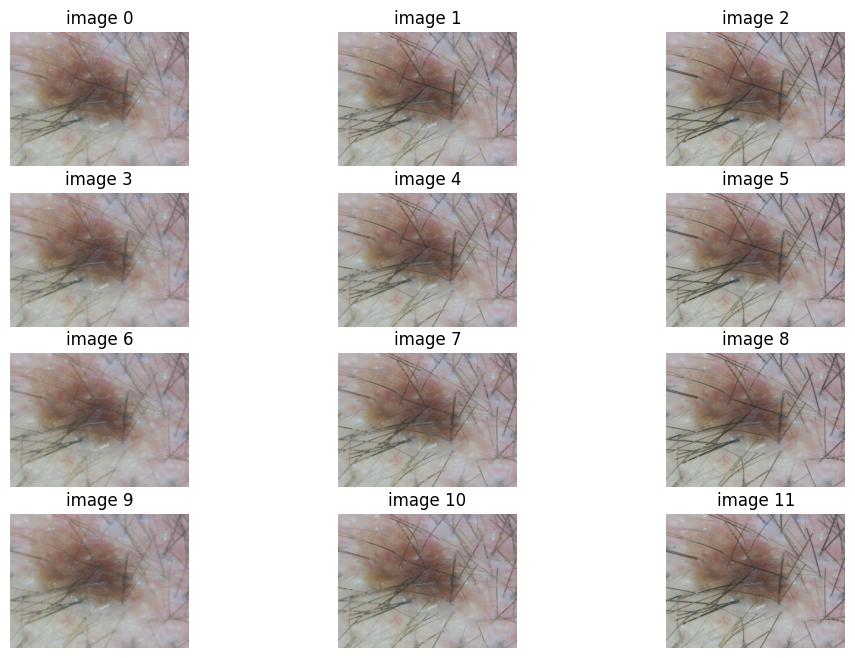

In [53]:
inpainted_imgs = []

for i in range(len(opening_images)):
    inpainted_img = cv2.inpaint(image_resized, opening_images[i], inpaintRadius=5, flags=cv2.INPAINT_NS)
    inpainted_imgs.append(inpainted_img)


plt.figure(figsize=(12, 8))
plt.tight_layout()
for i in range(len(inpainted_imgs)):
    plt.subplot(4, 3, i+1)
    plt.imshow(cv2.cvtColor(inpainted_imgs[i], cv2.COLOR_BGR2RGB))
    plt.title(f'image {i}')
    plt.axis('off')


(-0.5, 1023.5, 1023.5, -0.5)

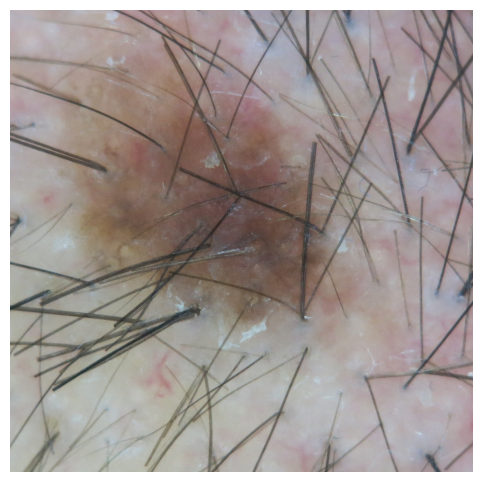

In [34]:
plt.figure(figsize=(12, 6))
img = cv2.imread(train_nevus[6])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

### 2nd approach

(-0.5, 799.5, 599.5, -0.5)

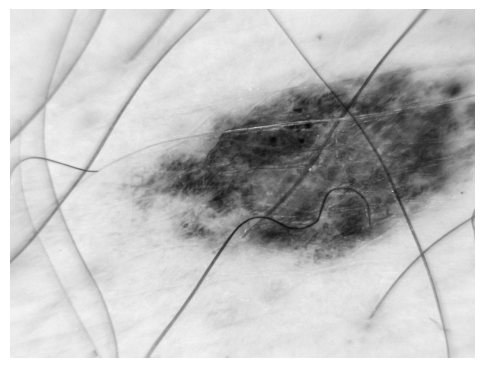

In [136]:
# Load the RGB image
image = cv2.imread(train_nevus[222])

image_resized = preprocessor.resize_images(image, preserve_ratio=True)


# Step 1: PCA transformation to enhance contrast
# Convert RGB to grayscale
img_grayscale = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

clip_limit = 1.0 # 10.0
tile_size = 10 # 6

CLAHE = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
img_CLAHE = CLAHE.apply(img_grayscale)



plt.figure(figsize=(6, 6))
plt.imshow(img_CLAHE, cmap='gray')
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

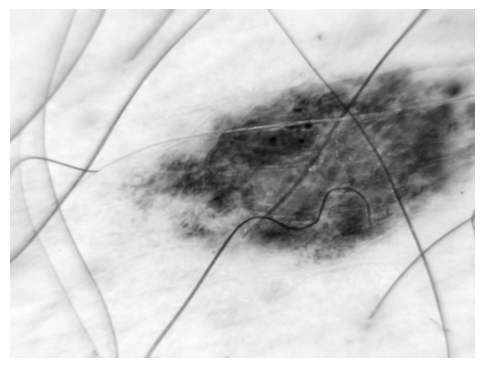

In [137]:
# Apply Gaussian filter
filter_size = 5
filtered_image = cv2.GaussianBlur(img_CLAHE, (filter_size, filter_size), 0)


plt.figure(figsize=(6, 6))
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

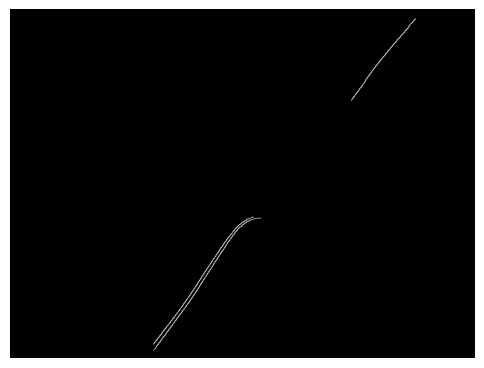

In [138]:
# Step 4: Improved Canny edge detection
# Calculate the median pixel value of the image
median_value = np.median(filtered_image)

# Define high and low thresholds for Canny
high_threshold = median_value + 75
low_threshold = median_value - 75

# Apply Canny edge detection with the selected thresholds
edges = cv2.Canny(filtered_image, low_threshold, high_threshold)

plt.figure(figsize=(6, 6))
plt.imshow(edges, cmap='gray')
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

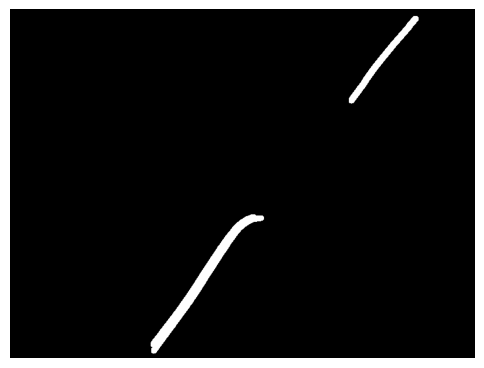

In [139]:
# Step 5: dilation
# Define the size of the dilation kernel (structuring element)
kernel_size = (10, 10)  # Adjust the size as needed

# Perform dilation
dilated_image = cv2.dilate(edges, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size))

plt.figure(figsize=(6, 6))
plt.imshow(dilated_image, cmap='gray')
plt.axis('off')

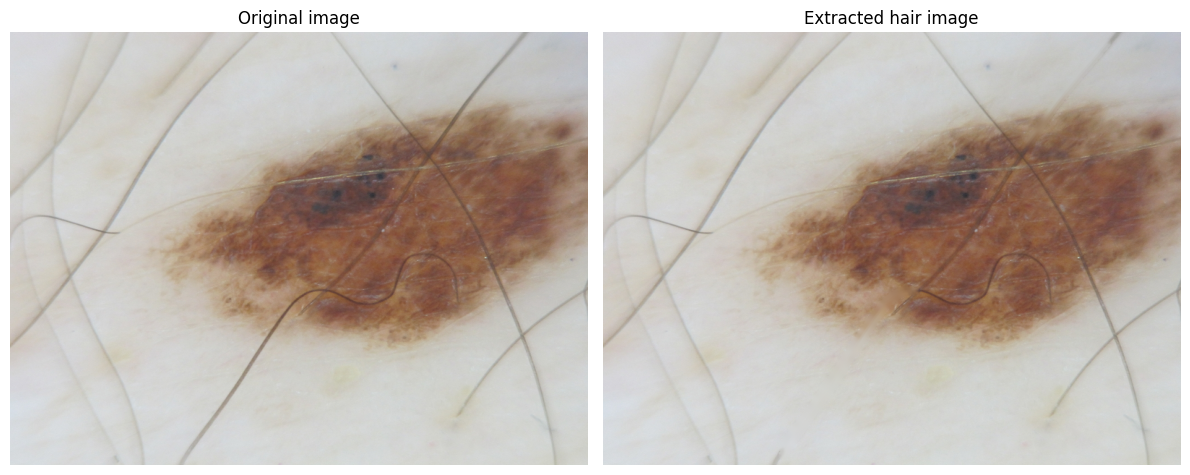

In [140]:
inpainted_img = cv2.inpaint(image_resized, dilated_image, inpaintRadius=5, flags=cv2.INPAINT_TELEA) # INPAINT_NS


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(inpainted_img, cv2.COLOR_BGR2RGB))
plt.title('Extracted hair image')
plt.axis('off')
plt.tight_layout()
